In [ ]:
import os
import sys
sys.path.append('/Users/abdielfer/RNCanWork/DL4Flood/')
from model_set.models import UNetFlood
from scr import util as U
from scr import dataLoader as D
from scr import models_trainer
from scr import losses as L
from scr.losses import iou_binary,binaryAccuracy
from rasterio.plot import show
import torch
from torch import nn
from torch.optim import Adam, SGD
import numpy as np

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

# Building *.scv files with imag-mask pair path.  (OK)

In [ ]:
filesPath = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\RawData\Class1'
pairImgMaskList = U.makeTifGpkgPairsList(filesPath)
csvPath = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\RawData\Class1RawData.csv'
U.createCSVFromList(csvPath,pairImgMaskList)

# Sampling
For sampling we consider all patches target as training "trn". Sinse all regions are toguether, to ensure representativity into the test set, the samping is made by region in proportions of 90% training and 10 % test.

20
secrets mean 25.25 secrets std : 4.403123891057348
random mean 25.25 random std 5.402545696243577


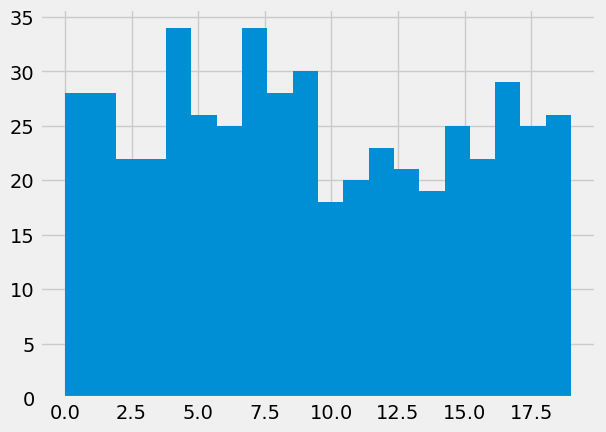

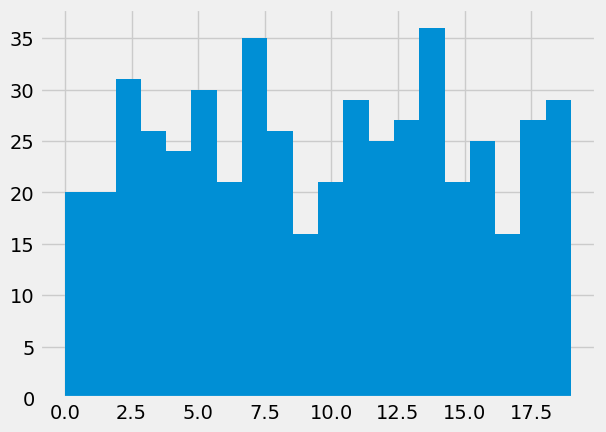

In [129]:
import random
import secrets
import matplotlib.pyplot as plt

L= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0]
print(len(L))
secure_random = secrets.SystemRandom()
somesSecretsFreq = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
secretsCumul = []
somesRandomsFreq = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
randomCuml = []
for i in range (0,101):
    somesSecrets = secure_random.sample(L,5)
    secretsCumul.extend(somesSecrets)
    for n in somesSecrets:
        somesSecretsFreq[n]+=1
    somesRandoms = random.sample(L,5)
    randomCuml.extend(somesRandoms)
    for m in somesRandoms:
        somesRandomsFreq[m]+=1
     
print(f"secrets mean {np.mean(somesSecretsFreq)} secrets std : {np.std(somesSecretsFreq)}")
print(f"random mean {np.mean(somesRandomsFreq)} random std {np.std(somesRandomsFreq)}")

def plotHist(x, binds):
    plt.hist(x, bins=binds)
    plt.show()

plotHist(secretsCumul, 20)
plotHist(randomCuml, 20)   
    

In [95]:
somesSecretsFreq = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
somesSecretsFreq[19]+=1
print(somesSecretsFreq)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


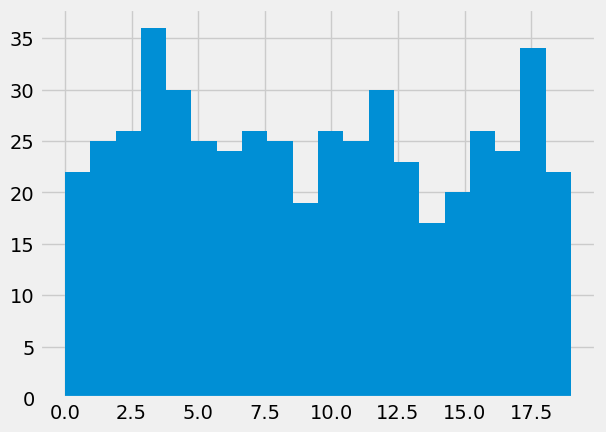

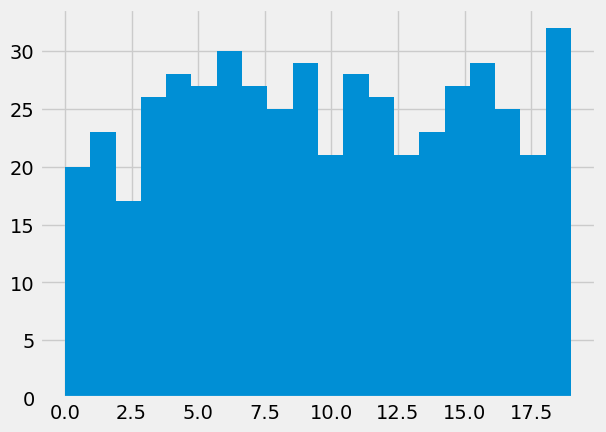

In [66]:
# enter the *.csv containing all pairs image-mask \
scvPath = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\template_project\val\listToTransform.csv'


# Verifying data agmentation

In [ ]:
print(listPath)

In [ ]:
### Transfer images by copy  ( OK )
img_list, mask_list = D.createImageMaskList(scvPath)
for i, m in zip(img_list, mask_list):
    U.makeFileCopy(i,saveImgDir)
    U.makeFileCopy(m,saveMaskDir)

In [ ]:
from rasterio.plot import show
saveDir = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\template_project\val\Rotated'
scvPath = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\template_project\val\listToTransform.csv'
img, mask = fullSet.__getitem__(3)
print(type(img))
# show(img)
# show(mask)

## In data agmentation- Make permanent transformations.
The permanent transformation is applied to the final trainig set. 

In [ ]:
scvPath = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\Percentage_1\Percentage_1_feat1_min-annot5_trn.csv'
Dir = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\Percentage_1\trn\TransformedRot180'
D.offlineTransformation(scvPath, Dir)

#NOTE: The first element in the scv list must be remouved. NO idea Why. 


# Testing train cycle  ( OK )

In [ ]:
datalistPath = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\Percentage_1\Percentage_1_feat1_min-annot5_trn_PlussRotated.csv'

# NOTE: We need to put r in front of the string, to denote raw string. Otherwise,'_' character will truncate the string 
args = {'batch_size': 1, 'num_workers': 4,'drop_last': True}

fullSet = D.customDataSet(datalistPath)
# img,mask=fullSet.__getitem__()
trainSet, valSet = D.splitDataset(fullSet)
print(f"Dataset lens : train: {trainSet.__len__()} :-- valSet: {valSet.__len__()}")

train_set = D.customDataloader(trainSet,args)  #.getDataloader()     
val_set = D.customDataloader(valSet,args)  #.getDataloader()
# rasterPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/trn/VilleGatineau-1/images/'

In [ ]:
model = UNetFlood(1,1)
# loss_fn = nn.CrossEntropyLoss() if model.classes > 1 else nn.BCEWithLogitsLoss()
loss_fn = L.lovasz_hinge

optimizer = Adam(model.parameters(), lr = 0.001) #SGD(model.parameters(), lr=0.001, momentum=0.9)##  

trainer = models_trainer.models_trainer(model,loss_fn,optimizer, iou_binary)
trainer.set_loaders(train_set,val_set)

In [ ]:
with U.timeit():
    trainer.train(20)

In [ ]:
# trainer.load_checkpoint('2304061151')
id = U.makeNameByTime()
U.saveModel(model, id)

In [ ]:
trainer.save_checkpoint(id)

# Testing metric computation (OK)

In [ ]:
from torch.nn.functional import sigmoid
import matplotlib.pyplot as plt

def _computeMetricPerMiniBatch(data_loader, metric_fn, model):
        '''
        Return de mean per batch of the metric in self.metric  
        '''
        metrics = []
        miniBathcMetric = []
        for x_batch, y_batch in data_loader:
            metric=[]
            print(f"Batch = {i}")
            i+=1
            for x,y in zip(x_batch, y_batch):
                yHat = model(torch.unsqueeze(x,0))
                y_hat_sigmoid = torch.round(sigmoid(yHat)).to(torch.int32)
                y_item= y.numpy() if torch.is_tensor(y) else y.numpy().squeeze()
                y_hat_item = y_hat_sigmoid.detach().numpy().squeeze() if torch.is_tensor(y_hat_sigmoid) else y_hat_sigmoid.numpy().squeeze()
                metricPerImage = metric_fn(y_hat_item, y_item)
                metric.append(metricPerImage)    
            ItemMetric = Average(metric)
            miniBathcMetric.append(ItemMetric)
        metricMean = Average(miniBathcMetric)
        return metricMean

def plotImageAndMask(img, img1,mask,imgName:str='Image', img1Name:str='Image1', mskName: str= 'Mask'):
    # colList = ['Image','Mask']
    image = img.detach().numpy() if torch.is_tensor(img) else img.numpy().squeeze()
    image1 = img1.detach().numpy() if torch.is_tensor(img1) else img1.numpy().squeeze()
    mask_squeezed = mask.detach().numpy() if torch.is_tensor(mask) else mask.numpy().squeeze()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    axs[0].imshow(image, cmap='Greys_r')
    axs[0].set(xlabel= imgName)
    axs[1].imshow(image1, cmap='Greys_r')
    axs[1].set(xlabel= img1Name)
    axs[2].imshow(mask_squeezed, cmap='Greys_r')
    axs[2].set(xlabel= mskName)
    plt.rcParams['font.size'] = '15'
    fig.tight_layout()
   
def Average(lst):
    ave = sum(lst) / len(lst)
    return round(ave,2)

In [ ]:
metric_fn = L.iou_binary
model = trainer.getModel()
with torch.no_grad():
    metric = _computeMetricPerMiniBatch(val_set, metric_fn, model)

In [ ]:
print(F"Final matric value {metric}")

In [ ]:
item = next(iter(val_set))
imag = item[0]
mask = item[1]
print('image to model input shape',imag.shape)

model.eval()
Y_hat = model(imag)
print('Y_hat to model input shape',Y_hat.shape)
model.train()


In [ ]:
for i in range(0,imag.shape[0]):
    U.plotImageAndMask(Y_hat[i][0], mask[i][0])


In [ ]:
##  Works well!
# Testing util.makePredictionRaster() for inference.
inToInfer,_ = U.readRaster(rasterPath)

imgToInferTensor = U.imageToTensor(inToInfer)
print("imgToInferTensor shape: ----", imgToInferTensor.shape)
out = U.makePredictionRaster(rasterPath, model,saveRaster=True)
print('out shape: _____ ',out.shape)


## Testing IoU in modified mask (OK)

In [ ]:
#test IoU
# Modified mask: righ up corner have been removed from real mask in QGIS. Both share CRS, resolution, ect. 
parentDir = r'C:\Users\abfernan\CrossCanFloodMapping\RawData\SyntheticPredictionandMask'
realMask = 'mask1.tif'
modifiedMask = 'SintheticGT1_1.tif'

maskPath = os.path.join(parentDir,realMask)
gtPath = os.path.join(parentDir, modifiedMask)
print(maskPath, gtPath)

real,_ = U.readRaster(maskPath)
modified,_ = U.readRaster(gtPath)

ioUB = iou_binary(real,modified)
print(f"iou_binary : {ioUB}")

realTensor = U.imageToTensor(real)
modifiedTensor = U.imageToTensor(modified)

print(f"binaryAccuracy : {binaryAccuracy(realTensor,modifiedTensor)}")

U.plotImageAndMask(U.imageToTensor(real)[0],U.imageToTensor(modified)[0],'original mask','modified mask')

#  OUTPUT = 87,987% iou, is a good representation of mask differences. 

In [ ]:
U.plotImageAndMask(imgToInferTensor[0],rasterData[0])

In [ ]:
import torch as T
from torch.autograd import Variable

In [ ]:
flated = Y_hat[0][0].view(-1)
signs = 2. * Y_hat[0][0].float() - 1.
# print(Y_hat[0][0][0:20,340:350])
# print('signe : ____',signs[0:20,340:350])
# print(signs.shape)
zerosAndOnes = torch.where(signs==-1,torch.tensor(0),signs)
# print(zerosAndOnes[0:20,340:350])
errors = (1. - Y_hat[0][0] * Variable(signs))
U.plotImageAndMask(Y_hat[0][0], zerosAndOnes)
ioUB = L.iou_binary(zerosAndOnes,zerosAndOnes, per_image=False)
print(ioUB)

In [ ]:
####   Apply sigmoid to the output image to compare with Mask...IMportant!!!!
y_hatSigmoided = torch.sigmoid(Y_hat[0][0])
U.plotImageAndMask(y_hatSigmoided, mask[0][0])

In [ ]:
### Visualize all batch image-mask pairs. 
# NOTE :   img, mask = next(iter(train_set))
i = 0
j = 0
for batch in train_set:
    for item in batch:
        print(f"Bathc {i}, item {j}")
        print('item',item.shape)
        j +=1
        
    # U.plotImageAndMask(batch[0][0],batch[1][0])
    i+=1
    j=0  
    print("_______") 


# Things to test: 
## Image visualization.

In [ ]:
## Ref: 

from typing import Iterable, List
import torch
import matplotlib.pyplot as plt

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='gray')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

In [ ]:

from pathlib import  Path
import xarray as xr
import matplotlib.pyplot as plt

root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()
     

idx = 0
img = xr.open_rasterio(train_imgs[idx])
mask = xr.open_rasterio(train_masks[idx])
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues')

# Cleaning sampling from GDL.  (OK)
### GDL sampling includes images with no mask matching. In this section we remove unnecessary files.  

In [ ]:
# 1-recorrer el directorio y crear lista de todos los *.tif. 2-importar *.csv list of images and mask.
# 3-compara cada nombre en la lista de *.tif con los de la lista from *.csv, 4- si no esta en la lista, borrar.
scvPath = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\Percentage_1\Percentage_1_feat1_min-annot5_trn.csv'
imagDir = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\Percentage_1\trn'
Dir = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\Percentage_1\trn'

# tifList = U.listALLFilesInDirByExt(Dir, ext='.tif')
# print(f"Jupyter Nbk All available *tif :  {len(tifList)}")
noMatchList = U.noMatch_TifMask_List(scvPath,imagDir,relocate = True, relocatePath = Dir)

In [ ]:
imagDir = r'C:\Users\abfernan\CrossCanFloodMapping\DatasetCNNFlood\C1Dataset\Done\template_project\trn'
tifList = U.listALLFilesInDirByExt_fullPath(imagDir, ext='.tif')

In [ ]:
print(f"tifList list len {len(tifList)}")
print(tifList[0])

## Check in for Operative System  (.OK)

In [ ]:
from sys import platform
def getPlatform():
    OPS = ''
    if platform == "darwin":
        OPS = "mac"
    elif platform == "win32":
        OPS = "win"
    return OPS 

####   

OPS = getPlatform()

if OPS == 'mac': 
    configPath = 'config\configMac.yaml'
elif OPS == 'win':
    configPath = 'config\configPC.yaml'

print(OPS)